<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,scipy,pandas,sklearn,mlxtend

last updated: 2017-03-29 

CPython 2.7.10
IPython 5.3.0

numpy 1.12.0
scipy 0.15.1
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.5.1


# Energy reconstruction
### Table of contents
1. [Data preprocessing](#Data-preprocessing)
2. [Weight simulation events to spectrum](#Weight-simulation-events-to-spectrum)
3. [S125 verification](#S125-verification)
4. [$\log_{10}(\mathrm{dE/dX})$ verification](#$\log_{10}(\mathrm{dE/dX})$-verification)

In [42]:
from __future__ import division, print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn.apionly as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.externals import joblib

import composition as comp
import composition.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

%matplotlib inline

# Data preprocessing
[ [back to top](#top) ]
1. Load simulation/data dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets
4. Feature selection

### Load simulation, format feature and target matrices

In [3]:
feature_list = ['lap_cos_zenith', 'log_s125']
# feature_list = ['lap_cos_zenith', 'log_s125', 'NStations', 'IceTop_charge']
# feature_list = ['lap_cos_zenith', 'lap_log_energy', 'log_s125', 'NStations', 'IceTop_charge']
# feature_list = ['lap_cos_zenith', 'NStations', 'Laputop_IceTop_FractionContainment', 'IceTop_charge']
sim_train, sim_test = comp.analysis.preprocess_sim(feature_list=feature_list, target='MC_energy',
                                                   labelencode=False, return_comp=True)

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
              InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75
             reco_energy_range:  0.837  0.623


Selecting the following features:
	$\cos(\theta_{\mathrm{Lap}})$
	$\log_{10}(S_{\mathrm{125}})$
	
Number training events = 223211
Number testing events = 24801


In [4]:
nan_mask_train = ~np.isnan(sim_train.X).any(axis=1)
nan_mask_test = ~np.isnan(sim_test.X).any(axis=1)

In [5]:
sim_train = sim_train[nan_mask_train]
sim_test = sim_test[nan_mask_test]

In [6]:
df_sim = comp.load_dataframe(datatype='sim', config='IC79')
df_sim.dropna(inplace=True)
feature_list, feature_labels = comp.analysis.get_training_features(feature_list)

sim quality cut event flow:
             IceTopQualityCuts:    1.0    1.0
         lap_InIce_containment:  0.776  0.776
              InIceQualityCuts:  0.786   0.75
                 num_hits_1_60:  0.999   0.75
             reco_energy_range:  0.837  0.623




/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


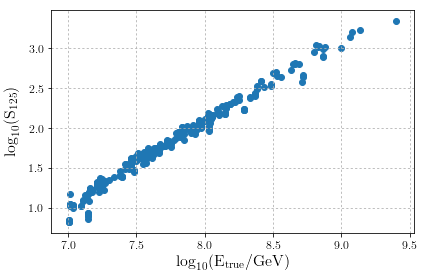

In [7]:
fig, ax = plt.subplots()
ax.scatter(df_sim['MC_log_energy'][:300], df_sim['log_s125'][:300])
ax.set_xlabel('$\mathrm{\\log_{10}(E_{true}/GeV)}$')
ax.set_ylabel('$\mathrm{\\log_{10}(S_{125})}$')
ax.grid()
plt.show()

In [8]:
sim_train.X.shape

(223211, 2)

In [9]:
# clf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=2)
clf = RandomForestRegressor(n_estimators=50, n_jobs=5, random_state=2)

In [21]:
def plot_validation_curve(validation_dict, param_name, ylime=None, ax=None):
    
    if ax is None:
        ax = plt.gca()
        
    ax.plot(validation_dict['range'], validation_dict['train_mean'], label="Training score",
             color='C0')
    ax.fill_between(validation_dict['range'], validation_dict['train_mean'] - validation_dict['train_std'],
                     validation_dict['train_mean'] + validation_dict['train_std'], alpha=0.2,
                     color='C0')
    
    ax.plot(validation_dict['range'], validation_dict['test_mean'], label="Cross-validation score",
                 color='C2')
    ax.fill_between(validation_dict['range'], validation_dict['test_mean'] - validation_dict['test_std'],
                     validation_dict['test_mean'] + validation_dict['test_std'], alpha=0.2,
                     color='C2')
    
    ax.set_xlabel(param_name)
    ax.set_ylabel('Median energy resolution')
    ax.grid()
    ax.legend()
    
    return ax

### Define scoring function

In [10]:
def median_energy_res(y, y_pred):
    return np.median(np.log10(y/y_pred))
scorer = make_scorer(median_energy_res, greater_is_better=False)

## Validation curve for maximum tree depth

In [12]:
max_depth_validation = {}
max_depth_validation['range'] = np.arange(1, 11)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='max_depth', param_range=max_depth_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
max_depth_validation['train_mean'] = np.mean(train_scores, axis=1)
max_depth_validation['train_std'] = np.std(train_scores, axis=1)
max_depth_validation['test_mean'] = np.mean(test_scores, axis=1)
max_depth_validation['test_std'] = np.std(test_scores, axis=1)

[CV] max_depth=1 .....................................................
[CV] max_depth=2 .....................................................
[CV] max_depth=3 .....................................................
[CV] max_depth=4 .....................................................
[CV] max_depth=5 .....................................................
[CV] ...................................... max_depth=1, total=   1.3s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=2, total=   2.1s
[CV] max_depth=7 .....................................................
[CV] ...................................... max_depth=3, total=   3.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=4, total=   3.7s
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=5, total=   4.1s
[CV] m

[Parallel(n_jobs=5)]: Done  50 out of 100 | elapsed:   50.1s remaining:   50.1s


[CV] ...................................... max_depth=9, total=   7.4s
[CV] max_depth=6 .....................................................
[CV] ...................................... max_depth=3, total=   2.8s
[CV] max_depth=7 .....................................................
[CV] ..................................... max_depth=10, total=   7.1s
[CV] max_depth=8 .....................................................
[CV] ...................................... max_depth=4, total=   3.4s
[CV] max_depth=9 .....................................................
[CV] ...................................... max_depth=5, total=   4.1s
[CV] max_depth=10 ....................................................
[CV] ...................................... max_depth=6, total=   4.7s
[CV] max_depth=1 .....................................................
[CV] ...................................... max_depth=7, total=   6.0s
[CV] max_depth=2 .....................................................
[CV] .

[Parallel(n_jobs=5)]: Done 100 out of 100 | elapsed:  1.7min finished


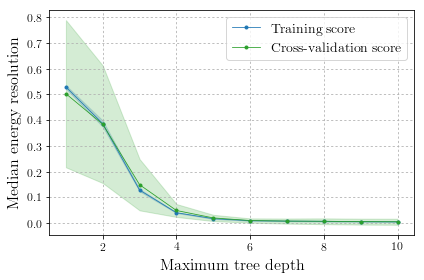

In [22]:
fig, ax = plt.subplots()
ax = plot_validation_curve(max_depth_validation, 'Maximum tree depth', ax=ax)
plt.show()

In [14]:
max_depth_validation

{'range': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 'test_mean': array([ 0.50255475,  0.3839728 ,  0.14932636,  0.04934139,  0.02041614,
         0.0103807 ,  0.00827866,  0.00750279,  0.00609946,  0.00564338]),
 'test_std': array([ 0.2856297 ,  0.22810723,  0.09949119,  0.0250328 ,  0.01215241,
         0.0083085 ,  0.00996272,  0.01126581,  0.01158005,  0.01175209]),
 'train_mean': array([ 0.52882301,  0.38635185,  0.12845208,  0.04070192,  0.01760879,
         0.00977809,  0.00807251,  0.00724977,  0.00594708,  0.00528878]),
 'train_std': array([ 0.00635995,  0.01219002,  0.00465081,  0.00136199,  0.00076338,
         0.00056396,  0.00047198,  0.00055677,  0.00057028,  0.00056188])}

In [30]:
clf.set_params(max_depth=20)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=50, n_jobs=5, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

In [18]:
n_estimators_validation = {}
n_estimators_validation['range'] = np.arange(10, 500, 100)
train_scores, test_scores = validation_curve(clf, sim_train.X, sim_train.y,
                                param_name='n_estimators', param_range=n_estimators_validation['range'],
                                cv=10, scoring=scorer, n_jobs=5, verbose=2)
n_estimators_validation['train_mean'] = np.mean(train_scores, axis=1)
n_estimators_validation['train_std'] = np.std(train_scores, axis=1)
n_estimators_validation['test_mean'] = np.mean(test_scores, axis=1)
n_estimators_validation['test_std'] = np.std(test_scores, axis=1)

[CV] n_estimators=10 .................................................
[CV] n_estimators=110 ................................................
[CV] n_estimators=210 ................................................
[CV] n_estimators=310 ................................................
[CV] n_estimators=410 ................................................
[CV] .................................. n_estimators=10, total=   1.4s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.8s
[CV] n_estimators=110 ................................................
[CV] ................................. n_estimators=110, total=  15.5s
[CV] n_estimators=210 ................................................
[CV] ................................. n_estimators=110, total=  16.1s
[CV] n_estimators=310 ................................................
[CV] ................................. n_estimators=210, total=  29.1s
[CV] n

[Parallel(n_jobs=5)]: Done  25 out of  50 | elapsed:  2.9min remaining:  2.9min


[CV] ................................. n_estimators=210, total=  29.5s
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   3.3s
[CV] n_estimators=110 ................................................
[CV] ................................. n_estimators=310, total=  46.0s
[CV] n_estimators=210 ................................................
[CV] ................................. n_estimators=110, total=  15.5s
[CV] n_estimators=310 ................................................
[CV] ................................. n_estimators=310, total=  44.0s
[CV] n_estimators=410 ................................................
[CV] ................................. n_estimators=410, total= 1.0min
[CV] n_estimators=10 .................................................
[CV] .................................. n_estimators=10, total=   1.5s
[CV] n_estimators=110 ................................................
[CV] .

[Parallel(n_jobs=5)]: Done  50 out of  50 | elapsed:  5.9min finished


In [19]:
n_estimators_validation

{'range': array([ 10, 110, 210, 310, 410]),
 'test_mean': array([ 0.00548868,  0.00557944,  0.00558756,  0.00561756,  0.00561365]),
 'test_std': array([ 0.01186723,  0.01175808,  0.01175578,  0.01177776,  0.01176778]),
 'train_mean': array([ 0.00516754,  0.00529662,  0.00528581,  0.00528698,  0.00528427]),
 'train_std': array([ 0.00056915,  0.00057155,  0.00057321,  0.00056888,  0.00056973])}

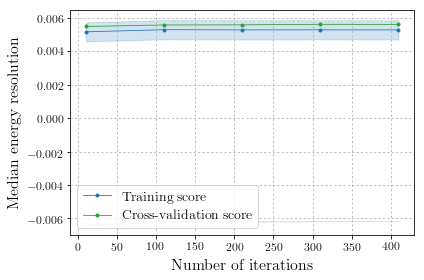

In [20]:
fig, ax = plt.subplots()
ax = plot_validation_curve(n_estimators_validation, 'Number of iterations', ax=ax)
plt.show()

In [36]:
clf.set_params(n_estimators=200)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=5, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

In [37]:
clf = clf.fit(sim_train.X, sim_train.y)
train_pred = clf.predict(sim_train.X)
# train_acc = mean_squared_error(sim_train.y, train_pred)
train_score = median_energy_res(sim_train.y, train_pred)

test_pred = clf.predict(sim_test.X)
# test_acc = mean_squared_error(sim_test.y, test_pred)
test_score = median_energy_res(sim_test.y, test_pred)
print('Testing score: {}'.format(test_score))
print('Training score: {}'.format(train_score))

Testing score: -0.00309242751178
Training score: -0.00238709415859


In [38]:
energy_bins = 10**np.arange(5.0, 9.51, 0.1)
energy_midpoints = (energy_bins[1:] + energy_bins[:-1]) / 2

In [39]:
light_mask = sim_test.comp == 'light'
heavy_mask = sim_test.comp == 'heavy'

In [40]:
energy_resolution = np.log10(test_pred/sim_test.y)
_, bin_medians_light, error_light = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[light_mask],
                                                                           energy_resolution[light_mask],
                                                                           np.log10(energy_bins))
_, bin_medians_heavy, error_heavy = comp.analysis.data_functions.get_medians(np.log10(sim_test.y)[heavy_mask],
                                                                           energy_resolution[heavy_mask],
                                                                           np.log10(energy_bins))

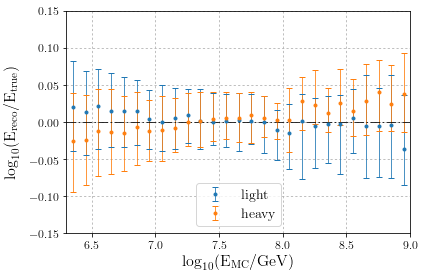

In [41]:
fig, ax = plt.subplots()
ax.errorbar(np.log10(energy_midpoints), bin_medians_light, yerr=error_light,
            marker='.', ls='None', label='light')
ax.errorbar(np.log10(energy_midpoints), bin_medians_heavy, yerr=error_heavy,
            marker='.', ls='None', label='heavy')
ax.axhline(0, marker='None', linestyle='-.', color='k')
ax.set_xlabel('$\mathrm{\log_{10}(E_{MC}/GeV)}$')
ax.set_ylabel('$\mathrm{\log_{10}(E_{reco}/E_{true})}$')
ax.set_xlim([6.3, 9.0])
ax.set_ylim([-0.15, 0.15])
ax.legend()
plt.grid()
# plt.savefig('/home/jbourbeau/public_html/figures/lap-energyres.png')
plt.show()

In [43]:
joblib.dump(clf, 'regressor.pkl') 

['regressor.pkl']